In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
import datetime
import copy

from sklearn.linear_model import LinearRegression

# Time series decomposition
#!pip install stldecompose
from statsmodels.tsa.filters._utils import  _get_pandas_wrapper
from statsmodels.tsa.seasonal import STL
# from stldecompose import decompose
from statsmodels.tsa.seasonal import seasonal_decompose


# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

In [2]:
df = pd.read_csv('OVHCLOUD_2024-06-11_10years.txt', sep="\t")
df.drop(df.columns[len(df.columns)-1], axis=1, inplace=True) # cleaning bugged last column
# df = df.set_index('date')
df.date = pd.to_datetime(df.date, dayfirst = True, format="%d/%m/%Y %H:%M")

In [3]:
df['EMA_9'] = df['clot'].ewm(9).mean().shift()
df['SMA_5'] = df['clot'].rolling(5).mean().shift()
df['SMA_10'] = df['clot'].rolling(10).mean().shift()
df['SMA_15'] = df['clot'].rolling(15).mean().shift()
df['SMA_30'] = df['clot'].rolling(30).mean().shift()

In [4]:
def relative_strength_idx(df, n=14):
    close = df['clot']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

df['RSI'] = relative_strength_idx(df).fillna(0)

In [5]:
EMA_12 = pd.Series(df['clot'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(df['clot'].ewm(span=26, min_periods=26).mean())
df['MACD'] = pd.Series(EMA_12 - EMA_26)
df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())

In [6]:
# new feature creation : SMA previouses
adjusted_copy = df['SMA_5']
#adjusted_copy = adjusted_copy.reset_index().drop(columns="index")
features = []
for i in range(len(adjusted_copy) - 3):
    features.append(adjusted_copy.iloc[i:i+3].tolist())
    #correction of the -3 in loop
features = [[np.nan, np.nan, np.nan],
 [np.nan, np.nan, np.nan],
 [np.nan, np.nan, np.nan]
] + features
df['SMA_5_3dfeature'] = features

adjusted_copy = df['SMA_10']
adjusted_copy = adjusted_copy.reset_index().drop(columns="index")
features = []
for i in range(len(adjusted_copy) - 3):
    features.append(adjusted_copy.iloc[i:i+3]['SMA_10'].tolist())
features = [[np.nan, np.nan, np.nan],
 [np.nan, np.nan, np.nan],
 [np.nan, np.nan, np.nan]
] + features
df['SMA_10_3dfeature'] = features

adjusted_copy = df['SMA_15']
adjusted_copy = adjusted_copy.reset_index().drop(columns="index")
features = []
for i in range(len(adjusted_copy) - 3):
    features.append(adjusted_copy.iloc[i:i+3]['SMA_15'].tolist())
features = [[np.nan, np.nan, np.nan],
 [np.nan, np.nan, np.nan],
 [np.nan, np.nan, np.nan]
] + features
df['SMA_15_3dfeature'] = features

adjusted_copy = df['SMA_30']
adjusted_copy = adjusted_copy.reset_index().drop(columns="index")
features = []
for i in range(len(adjusted_copy) - 3):
    features.append(adjusted_copy.iloc[i:i+3]['SMA_30'].tolist())
features = [[np.nan, np.nan, np.nan],
 [np.nan, np.nan, np.nan],
 [np.nan, np.nan, np.nan]
] + features
df['SMA_30_3dfeature'] = features

# MACD

adjusted_copy = df['MACD']
adjusted_copy = adjusted_copy.reset_index().drop(columns="index")
features = []
for i in range(len(adjusted_copy) - 3):
    features.append(adjusted_copy.iloc[i:i+3]['MACD'].tolist())
features = [[np.nan, np.nan, np.nan],
 [np.nan, np.nan, np.nan],
 [np.nan, np.nan, np.nan]
] + features
df['MACD_3dfeature'] = features

adjusted_copy = df['MACD_signal']
adjusted_copy = adjusted_copy.reset_index().drop(columns="index")
features = []
for i in range(len(adjusted_copy) - 3):
    features.append(adjusted_copy.iloc[i:i+3]['MACD_signal'].tolist())
features = [[np.nan, np.nan, np.nan],
 [np.nan, np.nan, np.nan],
 [np.nan, np.nan, np.nan]
] + features
df['MACD_signal_3dfeature'] = features

# RSI

adjusted_copy = df['RSI']
adjusted_copy = adjusted_copy.reset_index().drop(columns="index")
features = []
for i in range(len(adjusted_copy) - 3):
    features.append(adjusted_copy.iloc[i:i+3]['RSI'].tolist())
features = [[np.nan, np.nan, np.nan],
 [np.nan, np.nan, np.nan],
 [np.nan, np.nan, np.nan]
] + features
df['RSI_3dfeature'] = features

In [7]:
# GET THE RIGHT RANGE
# 3d features on SMA_30 come clean at index 34, macd_signal requires 36
df = df.drop(index=range(36))
df = df.reset_index().drop(columns="index")
to_drop = ['date', 'ouv', 'haut', 'bas', 'devise', 'vol']
df = df.drop(columns=to_drop)
df

,clot,EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal,SMA_5_3dfeature,SMA_10_3dfeature,SMA_15_3dfeature,SMA_30_3dfeature,MACD_3dfeature,MACD_signal_3dfeature,RSI_3dfeature
0,21.600,20.716970,20.6650,20.5245,20.694000,20.826500,54.347826,0.013496,-0.079834,"[20.449, 20.503, 20.556]","[20.624000000000002, 20.569499999999998, 20.5095]","[20.642666666666667, 20.66166666666667, 20.685...","[20.924833333333332, 20.891166666666667, 20.85...","[-0.12086290618936602, -0.10003659519989228, -...","[-0.12325684877935711, -0.11805416404368656, -...","[53.927813163481964, 48.042704626334526, 59.61..."
1,21.400,20.807100,20.8970,20.6415,20.780667,20.838167,51.169188,0.055710,-0.051149,"[20.503, 20.556, 20.665]","[20.569499999999998, 20.5095, 20.5245]","[20.66166666666667, 20.685000000000002, 20.694]","[20.891166666666667, 20.853166666666663, 20.82...","[-0.10003659519989228, -0.06003391755240628, 0...","[-0.11805416404368656, -0.10535966563537397, -...","[48.042704626334526, 59.61538461538462, 54.347..."
2,21.340,20.867492,21.1140,20.7815,20.787333,20.826500,49.863388,0.083540,-0.022972,"[20.556, 20.665, 20.897000000000002]","[20.5095, 20.5245, 20.6415]","[20.685000000000002, 20.694, 20.780666666666665]","[20.853166666666663, 20.826500000000003, 20.83...","[-0.06003391755240628, 0.013495818479487554, 0...","[-0.10535966563537397, -0.07983449225404077, -...","[59.61538461538462, 54.34782608695652, 51.1691..."
3,21.465,20.915532,21.2280,20.8655,20.789000,20.833667,58.470765,0.113912,0.005403,"[20.665, 20.897000000000002, 21.114]","[20.5245, 20.6415, 20.7815]","[20.694, 20.780666666666665, 20.78733333333333]","[20.826500000000003, 20.83816666666667, 20.826...","[0.013495818479487554, 0.055709844713682344, 0...","[-0.07983449225404077, -0.05114860132925008, -...","[54.34782608695652, 51.16918844566709, 49.8633..."
4,21.525,20.971303,21.3710,20.9635,20.796667,20.850833,68.717949,0.140979,0.033304,"[20.897000000000002, 21.114, 21.228]","[20.6415, 20.7815, 20.8655]","[20.780666666666665, 20.78733333333333, 20.788...","[20.83816666666667, 20.826500000000003, 20.833...","[0.055709844713682344, 0.08353962412343208, 0....","[-0.05114860132925008, -0.02297172407154301, 0...","[51.16918844566709, 49.86338797814206, 58.4707..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
640,4.978,5.877240,4.9964,5.5442,5.842800,6.188567,22.724014,-0.717715,-0.670960,"[5.854, 5.5516, 5.2704]","[6.0825000000000005, 5.8823, 5.707700000000001]","[6.172, 6.0658666666666665, 5.959466666666668]","[6.6615, 6.4991, 6.345066666666667]","[-0.6644142434123159, -0.702599380579783, -0.7...","[-0.6262070724219262, -0.6414855340534976, -0....","[12.594458438287148, 16.318327974276528, 15.68..."
641,5.250,5.787316,4.7980,5.4230,5.747667,6.097833,28.656519,-0.677889,-0.672346,"[5.5516, 5.2704, 4.9964]","[5.8823, 5.707700000000001, 5.5442]","[6.0658666666666665, 5.959466666666668, 5.8427...","[6.4991, 6.345066666666667, 6.188566666666667]","[-0.702599380579783, -0.7304128141944108, -0.7...","[-0.6414855340534976, -0.6592709900816803, -0....","[16.318327974276528, 15.68244035979663, 22.724..."
642,5.480,5.733584,4.8280,5.3410,5.664333,6.039500,34.443746,-0.620614,-0.661999,"[5.2704, 4.9964, 4.798]","[5.707700000000001, 5.5442, 5.423]","[5.959466666666668, 5.8427999999999995, 5.7476...","[6.345066666666667, 6.188566666666667, 6.09783...","[-0.7304128141944108, -0.7177149309671886, -0....","[-0.6592709900816803, -0.6709597782587821, -0....","[15.68244035979663, 22.72401433691755, 28.6565..."
643,5.360,5.708226,5.0164,5.2840,5.593667,5.999667,35.162015,-0.578241,-0.645248,"[4.9964, 4.798, 4.828]","[5.5442, 5.423, 5.341]","[5.8427999999999995, 5.7476666666666665, 5.664...","[6.188566666666667, 6.097833333333333, 6.0395]","[-0.7177149309671886, -0.6778893537268624, -0....","[-0.6709597782587821, -0.6723456933523982, -0....","[22.72401433691755, 28.656518861681008, 34.443..."


# ESSAIS REELS

In [8]:
model5 = LinearRegression()
model5.fit(pd.DataFrame(df['SMA_5_3dfeature'].tolist()), df['SMA_5'])
score5 = model5.score(pd.DataFrame(df['SMA_5_3dfeature'].tolist()), df['SMA_5'])
print("R^2 Score:", score5)

# next_number = model.predict([[22.8924, 23.073, 23.122400000000003]])
# print("Predicted Next Number:", next_number)
model10 = LinearRegression()
model10.fit(pd.DataFrame(df['SMA_10_3dfeature'].tolist()), df['SMA_10'])
score10 = model10.score(pd.DataFrame(df['SMA_10_3dfeature'].tolist()), df['SMA_10'])
print("R^2 Score:", score10)

model15 = LinearRegression()
model15.fit(pd.DataFrame(df['SMA_15_3dfeature'].tolist()), df['SMA_15'])
score15 = model15.score(pd.DataFrame(df['SMA_15_3dfeature'].tolist()), df['SMA_15'])
print("R^2 Score:", score15)

model30 = LinearRegression()
model30.fit(pd.DataFrame(df['SMA_30_3dfeature'].tolist()), df['SMA_30'])
score30 = model30.score(pd.DataFrame(df['SMA_30_3dfeature'].tolist()), df['SMA_30'])
print("R^2 Score:", score30)

model_macd = LinearRegression()
model_macd.fit(pd.DataFrame(df['MACD_3dfeature'].tolist()), df['MACD'])
score_macd = model_macd.score(pd.DataFrame(df['MACD_3dfeature'].tolist()), df['MACD'])
print("R^2 Score macd :", score_macd)

model_macd_sig = LinearRegression()
model_macd_sig.fit(pd.DataFrame(df['MACD_signal_3dfeature'].tolist()), df['MACD_signal'])
score_macd_sig = model_macd_sig.score(pd.DataFrame(df['MACD_signal_3dfeature'].tolist()), df['MACD_signal'])
print("R^2 Score macd_signal :", score_macd_sig)

model_RSI = LinearRegression()
model_RSI.fit(pd.DataFrame(df['RSI_3dfeature'].tolist()), df['RSI'])
score_RSI = model_RSI.score(pd.DataFrame(df['RSI_3dfeature'].tolist()), df['RSI'])
print("R^2 Score rsi :", score_RSI)

R^2 Score: 0.9996013786363418
R^2 Score: 0.9998764699315262
R^2 Score: 0.9999447579333912
R^2 Score: 0.9999852094903262
R^2 Score macd : 0.9948575545276991
R^2 Score macd_signal : 0.9997652118589384
R^2 Score rsi : 0.873986059497732


In [9]:
df

,clot,EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal,SMA_5_3dfeature,SMA_10_3dfeature,SMA_15_3dfeature,SMA_30_3dfeature,MACD_3dfeature,MACD_signal_3dfeature,RSI_3dfeature
0,21.600,20.716970,20.6650,20.5245,20.694000,20.826500,54.347826,0.013496,-0.079834,"[20.449, 20.503, 20.556]","[20.624000000000002, 20.569499999999998, 20.5095]","[20.642666666666667, 20.66166666666667, 20.685...","[20.924833333333332, 20.891166666666667, 20.85...","[-0.12086290618936602, -0.10003659519989228, -...","[-0.12325684877935711, -0.11805416404368656, -...","[53.927813163481964, 48.042704626334526, 59.61..."
1,21.400,20.807100,20.8970,20.6415,20.780667,20.838167,51.169188,0.055710,-0.051149,"[20.503, 20.556, 20.665]","[20.569499999999998, 20.5095, 20.5245]","[20.66166666666667, 20.685000000000002, 20.694]","[20.891166666666667, 20.853166666666663, 20.82...","[-0.10003659519989228, -0.06003391755240628, 0...","[-0.11805416404368656, -0.10535966563537397, -...","[48.042704626334526, 59.61538461538462, 54.347..."
2,21.340,20.867492,21.1140,20.7815,20.787333,20.826500,49.863388,0.083540,-0.022972,"[20.556, 20.665, 20.897000000000002]","[20.5095, 20.5245, 20.6415]","[20.685000000000002, 20.694, 20.780666666666665]","[20.853166666666663, 20.826500000000003, 20.83...","[-0.06003391755240628, 0.013495818479487554, 0...","[-0.10535966563537397, -0.07983449225404077, -...","[59.61538461538462, 54.34782608695652, 51.1691..."
3,21.465,20.915532,21.2280,20.8655,20.789000,20.833667,58.470765,0.113912,0.005403,"[20.665, 20.897000000000002, 21.114]","[20.5245, 20.6415, 20.7815]","[20.694, 20.780666666666665, 20.78733333333333]","[20.826500000000003, 20.83816666666667, 20.826...","[0.013495818479487554, 0.055709844713682344, 0...","[-0.07983449225404077, -0.05114860132925008, -...","[54.34782608695652, 51.16918844566709, 49.8633..."
4,21.525,20.971303,21.3710,20.9635,20.796667,20.850833,68.717949,0.140979,0.033304,"[20.897000000000002, 21.114, 21.228]","[20.6415, 20.7815, 20.8655]","[20.780666666666665, 20.78733333333333, 20.788...","[20.83816666666667, 20.826500000000003, 20.833...","[0.055709844713682344, 0.08353962412343208, 0....","[-0.05114860132925008, -0.02297172407154301, 0...","[51.16918844566709, 49.86338797814206, 58.4707..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
640,4.978,5.877240,4.9964,5.5442,5.842800,6.188567,22.724014,-0.717715,-0.670960,"[5.854, 5.5516, 5.2704]","[6.0825000000000005, 5.8823, 5.707700000000001]","[6.172, 6.0658666666666665, 5.959466666666668]","[6.6615, 6.4991, 6.345066666666667]","[-0.6644142434123159, -0.702599380579783, -0.7...","[-0.6262070724219262, -0.6414855340534976, -0....","[12.594458438287148, 16.318327974276528, 15.68..."
641,5.250,5.787316,4.7980,5.4230,5.747667,6.097833,28.656519,-0.677889,-0.672346,"[5.5516, 5.2704, 4.9964]","[5.8823, 5.707700000000001, 5.5442]","[6.0658666666666665, 5.959466666666668, 5.8427...","[6.4991, 6.345066666666667, 6.188566666666667]","[-0.702599380579783, -0.7304128141944108, -0.7...","[-0.6414855340534976, -0.6592709900816803, -0....","[16.318327974276528, 15.68244035979663, 22.724..."
642,5.480,5.733584,4.8280,5.3410,5.664333,6.039500,34.443746,-0.620614,-0.661999,"[5.2704, 4.9964, 4.798]","[5.707700000000001, 5.5442, 5.423]","[5.959466666666668, 5.8427999999999995, 5.7476...","[6.345066666666667, 6.188566666666667, 6.09783...","[-0.7304128141944108, -0.7177149309671886, -0....","[-0.6592709900816803, -0.6709597782587821, -0....","[15.68244035979663, 22.72401433691755, 28.6565..."
643,5.360,5.708226,5.0164,5.2840,5.593667,5.999667,35.162015,-0.578241,-0.645248,"[4.9964, 4.798, 4.828]","[5.5442, 5.423, 5.341]","[5.8427999999999995, 5.7476666666666665, 5.664...","[6.188566666666667, 6.097833333333333, 6.0395]","[-0.7177149309671886, -0.6778893537268624, -0....","[-0.6709597782587821, -0.6723456933523982, -0....","[22.72401433691755, 28.656518861681008, 34.443..."


In [10]:

def feature_prediction(df) :

    sma5_last3 = copy.deepcopy([df.loc[len(df.index)-1, 'SMA_5_3dfeature']]) # j-3 , j-2, j-1
    sma5_predict = model5.predict(sma5_last3)[0]
    sma5_last3[0].append(df.loc[len(df.index)-1, 'SMA_5']) # need to add last value
    sma5_last3[0].pop(0)

    sma10_last3 = copy.deepcopy([df.loc[len(df.index)-1, 'SMA_10_3dfeature']]) # j-3 , j-2, j-1
    sma10_predict = model10.predict(sma10_last3)[0]
    sma10_last3[0].append(df.loc[len(df.index)-1, 'SMA_10'])
    sma10_last3[0].pop(0)

    sma15_last3 = copy.deepcopy([df.loc[len(df.index)-1, 'SMA_15_3dfeature']]) # j-3 , j-2, j-1
    sma15_predict = model15.predict(sma15_last3)[0]
    sma15_last3[0].append(df.loc[len(df.index)-1, 'SMA_15'])
    sma15_last3[0].pop(0)

    sma30_last3 = copy.deepcopy([df.loc[len(df.index)-1, 'SMA_30_3dfeature']]) # j-3 , j-2, j-1
    sma30_predict = model30.predict(sma30_last3)[0]
    sma30_last3[0].append(df.loc[len(df.index)-1, 'SMA_30'])
    sma30_last3[0].pop(0)

    # MACD
    MACD_last3 = copy.deepcopy([df.loc[len(df.index)-1, 'MACD_3dfeature']])  # j-3 , j-2, j-1
    MACD_predict = model_macd.predict(MACD_last3)[0]
    MACD_last3[0].append(df.loc[len(df.index)-1, 'MACD'])
    MACD_last3[0].pop(0)

    MACD_signal_last3 = copy.deepcopy([df.loc[len(df.index)-1, 'MACD_signal_3dfeature']])  # j-3 , j-2, j-1
    MACD_signal_predict = model_macd_sig.predict(MACD_signal_last3)[0]
    MACD_signal_last3[0].append(df.loc[len(df.index)-1, 'MACD_signal'])
    MACD_signal_last3[0].pop(0)

    RSI_last3 = copy.deepcopy([df.loc[len(df.index)-1, 'RSI_3dfeature']]) # j-3 , j-2, j-1
    RSI_predict = model_RSI.predict(RSI_last3)[0]
    RSI_last3[0].append(df.loc[len(df.index)-1, 'RSI'])
    RSI_last3[0].pop(0)

    return [sma5_predict, sma10_predict, sma15_predict, sma30_predict, RSI_predict, MACD_predict, MACD_signal_predict], [sma5_last3, sma10_last3, sma15_last3, sma30_last3, MACD_last3, MACD_signal_last3, RSI_last3]


In [11]:
df

,clot,EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal,SMA_5_3dfeature,SMA_10_3dfeature,SMA_15_3dfeature,SMA_30_3dfeature,MACD_3dfeature,MACD_signal_3dfeature,RSI_3dfeature
0,21.600,20.716970,20.6650,20.5245,20.694000,20.826500,54.347826,0.013496,-0.079834,"[20.449, 20.503, 20.556]","[20.624000000000002, 20.569499999999998, 20.5095]","[20.642666666666667, 20.66166666666667, 20.685...","[20.924833333333332, 20.891166666666667, 20.85...","[-0.12086290618936602, -0.10003659519989228, -...","[-0.12325684877935711, -0.11805416404368656, -...","[53.927813163481964, 48.042704626334526, 59.61..."
1,21.400,20.807100,20.8970,20.6415,20.780667,20.838167,51.169188,0.055710,-0.051149,"[20.503, 20.556, 20.665]","[20.569499999999998, 20.5095, 20.5245]","[20.66166666666667, 20.685000000000002, 20.694]","[20.891166666666667, 20.853166666666663, 20.82...","[-0.10003659519989228, -0.06003391755240628, 0...","[-0.11805416404368656, -0.10535966563537397, -...","[48.042704626334526, 59.61538461538462, 54.347..."
2,21.340,20.867492,21.1140,20.7815,20.787333,20.826500,49.863388,0.083540,-0.022972,"[20.556, 20.665, 20.897000000000002]","[20.5095, 20.5245, 20.6415]","[20.685000000000002, 20.694, 20.780666666666665]","[20.853166666666663, 20.826500000000003, 20.83...","[-0.06003391755240628, 0.013495818479487554, 0...","[-0.10535966563537397, -0.07983449225404077, -...","[59.61538461538462, 54.34782608695652, 51.1691..."
3,21.465,20.915532,21.2280,20.8655,20.789000,20.833667,58.470765,0.113912,0.005403,"[20.665, 20.897000000000002, 21.114]","[20.5245, 20.6415, 20.7815]","[20.694, 20.780666666666665, 20.78733333333333]","[20.826500000000003, 20.83816666666667, 20.826...","[0.013495818479487554, 0.055709844713682344, 0...","[-0.07983449225404077, -0.05114860132925008, -...","[54.34782608695652, 51.16918844566709, 49.8633..."
4,21.525,20.971303,21.3710,20.9635,20.796667,20.850833,68.717949,0.140979,0.033304,"[20.897000000000002, 21.114, 21.228]","[20.6415, 20.7815, 20.8655]","[20.780666666666665, 20.78733333333333, 20.788...","[20.83816666666667, 20.826500000000003, 20.833...","[0.055709844713682344, 0.08353962412343208, 0....","[-0.05114860132925008, -0.02297172407154301, 0...","[51.16918844566709, 49.86338797814206, 58.4707..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
640,4.978,5.877240,4.9964,5.5442,5.842800,6.188567,22.724014,-0.717715,-0.670960,"[5.854, 5.5516, 5.2704]","[6.0825000000000005, 5.8823, 5.707700000000001]","[6.172, 6.0658666666666665, 5.959466666666668]","[6.6615, 6.4991, 6.345066666666667]","[-0.6644142434123159, -0.702599380579783, -0.7...","[-0.6262070724219262, -0.6414855340534976, -0....","[12.594458438287148, 16.318327974276528, 15.68..."
641,5.250,5.787316,4.7980,5.4230,5.747667,6.097833,28.656519,-0.677889,-0.672346,"[5.5516, 5.2704, 4.9964]","[5.8823, 5.707700000000001, 5.5442]","[6.0658666666666665, 5.959466666666668, 5.8427...","[6.4991, 6.345066666666667, 6.188566666666667]","[-0.702599380579783, -0.7304128141944108, -0.7...","[-0.6414855340534976, -0.6592709900816803, -0....","[16.318327974276528, 15.68244035979663, 22.724..."
642,5.480,5.733584,4.8280,5.3410,5.664333,6.039500,34.443746,-0.620614,-0.661999,"[5.2704, 4.9964, 4.798]","[5.707700000000001, 5.5442, 5.423]","[5.959466666666668, 5.8427999999999995, 5.7476...","[6.345066666666667, 6.188566666666667, 6.09783...","[-0.7304128141944108, -0.7177149309671886, -0....","[-0.6592709900816803, -0.6709597782587821, -0....","[15.68244035979663, 22.72401433691755, 28.6565..."
643,5.360,5.708226,5.0164,5.2840,5.593667,5.999667,35.162015,-0.578241,-0.645248,"[4.9964, 4.798, 4.828]","[5.5442, 5.423, 5.341]","[5.8427999999999995, 5.7476666666666665, 5.664...","[6.188566666666667, 6.097833333333333, 6.0395]","[-0.7177149309671886, -0.6778893537268624, -0....","[-0.6709597782587821, -0.6723456933523982, -0....","[22.72401433691755, 28.656518861681008, 34.443..."


# Model training

In [12]:
X = df.drop(columns = ["clot", "SMA_5_3dfeature", "SMA_10_3dfeature", "SMA_15_3dfeature",	"SMA_30_3dfeature", "MACD_3dfeature", "MACD_signal_3dfeature","RSI_3dfeature"])
y = df['clot']  # Target column

Mean Squared Error: 0.42981624202627655
R^2 Score: 0.8388619115912659


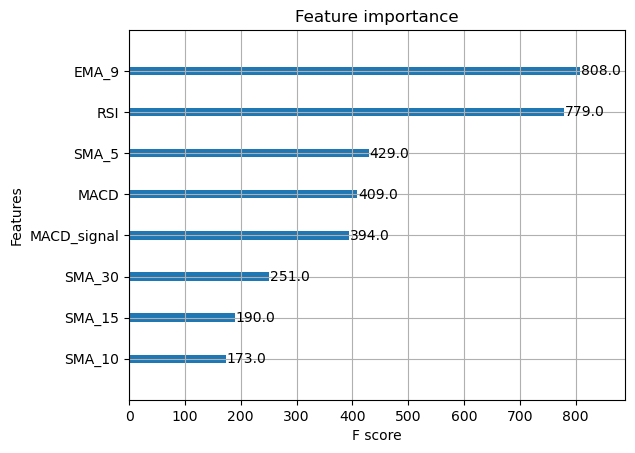

In [13]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score


# Split the data into training and testing sets
# Determine the split index
split_index = int(0.8 * len(df))

# Split the data into training and testing sets
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Initialize the XGBoost model
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Optional: Feature importance
import matplotlib.pyplot as plt

xgb.plot_importance(xgb_model)
plt.show()

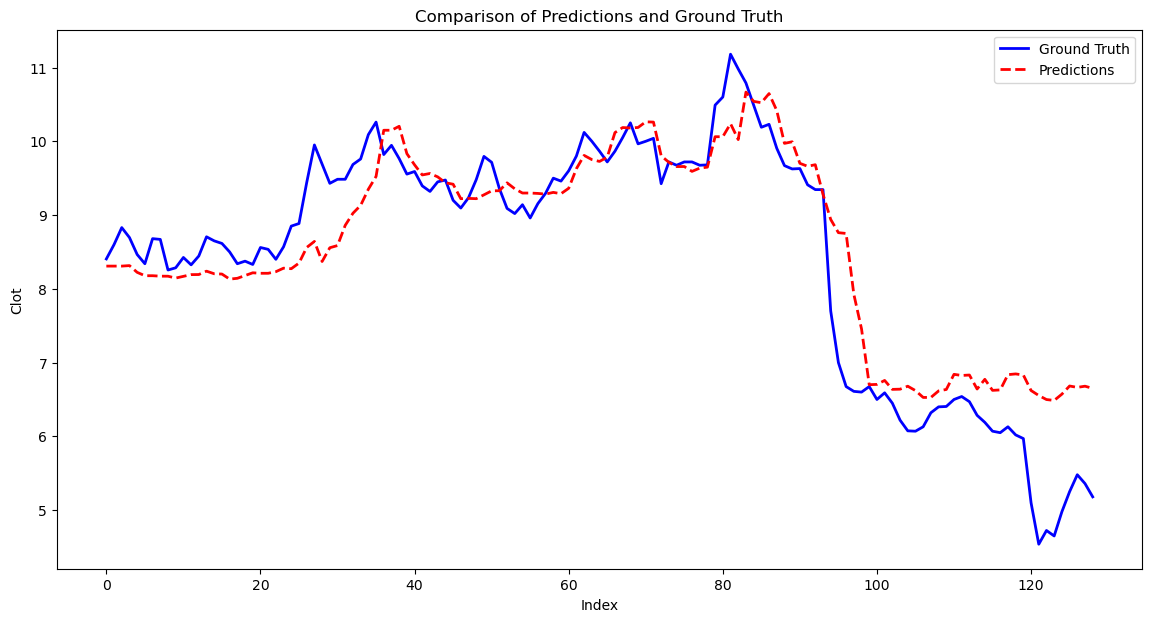

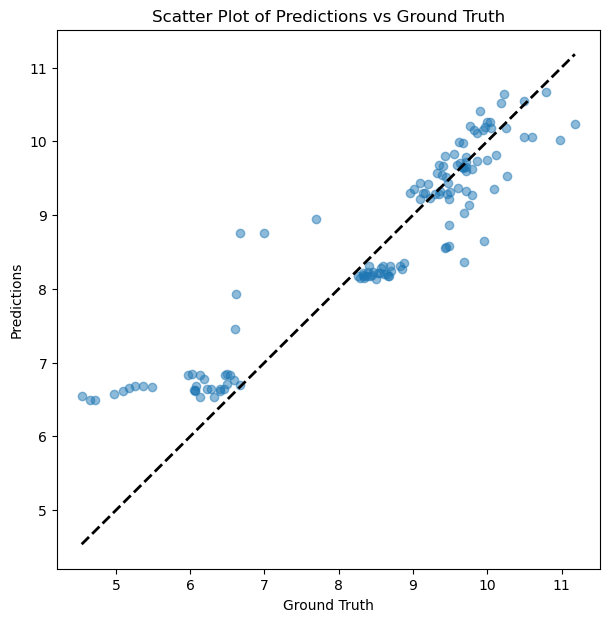

In [14]:
plt.figure(figsize=(14, 7))

plt.plot(y_test.values, label='Ground Truth', color='blue', linewidth=2)
plt.plot(y_pred, label='Predictions', color='red', linestyle='dashed', linewidth=2)

plt.title('Comparison of Predictions and Ground Truth')
plt.xlabel('Index')
plt.ylabel('Clot')
plt.legend()
plt.show()

# Scatter Plot to compare predictions with ground truth
plt.figure(figsize=(7, 7))

plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Line of perfect prediction
plt.title('Scatter Plot of Predictions vs Ground Truth')
plt.xlabel('Ground Truth')
plt.ylabel('Predictions')
plt.show()

# Now, train on the whole dataset

In [15]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the XGBoost model
xgb_model_all = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
xgb_model_all.fit(X, y)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

# Now automatize to add multiple days predictions

In [16]:
def predict_multiple_days(df, days) :
    
    pred_list = []

    for day in range(days) :

        pred, last3 = feature_prediction(df)

        # adding the line in the main df
        flattened_last3 = [item[0] for item in last3]
        df.loc[len(df.index)] = [np.nan, np.nan] + pred + flattened_last3 # [clot+ema9] + pred et last3
        last_ema9 = df['clot'].ewm(9).mean().shift()[len(df)-1]
        df.iloc[-1, df.columns.get_loc('EMA_9')] = last_ema9

        # Isolating today to make the prediction
        today = pd.DataFrame([[last_ema9] + pred], columns=['EMA_9', 'SMA_5', 'SMA_10', 'SMA_15', 'SMA_30', 'RSI', 'MACD', 'MACD_signal'])
        y_pred = xgb_model_all.predict(today)
        print("Prediction jour +"+ str(day+1) + " : " + str(y_pred))

        # Adding new clot value inside df
        df.iloc[-1, df.columns.get_loc('clot')] = y_pred

        pred_list.append(y_pred)

    return pred_list
    


In [17]:
predlist = predict_multiple_days(df, 10)

Prediction jour +1 : [5.4051504]
Prediction jour +2 : [5.416685]
Prediction jour +3 : [5.404181]
Prediction jour +4 : [5.4051504]
Prediction jour +5 : [5.413633]
Prediction jour +6 : [5.406514]
Prediction jour +7 : [5.4165187]
Prediction jour +8 : [5.6793656]
Prediction jour +9 : [5.44408]
Prediction jour +10 : [6.141764]


In [21]:
aa = [item[0] for item in predlist]

In [22]:
aa

[5.4051504,
 5.416685,
 5.404181,
 5.4051504,
 5.413633,
 5.406514,
 5.4165187,
 5.6793656,
 5.44408,
 6.141764]

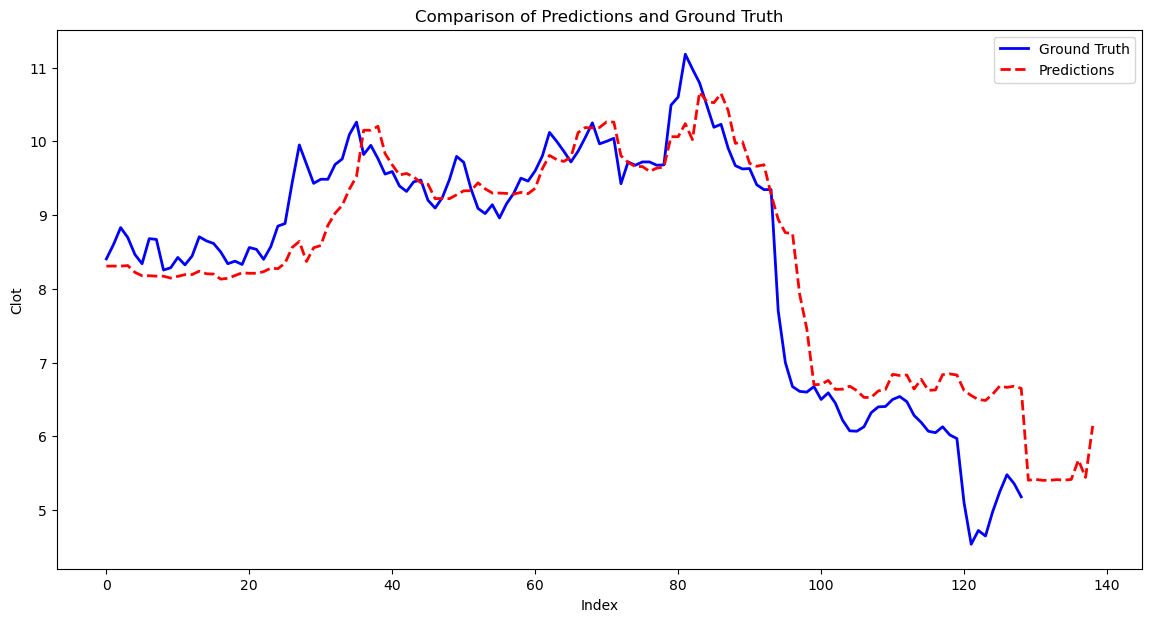

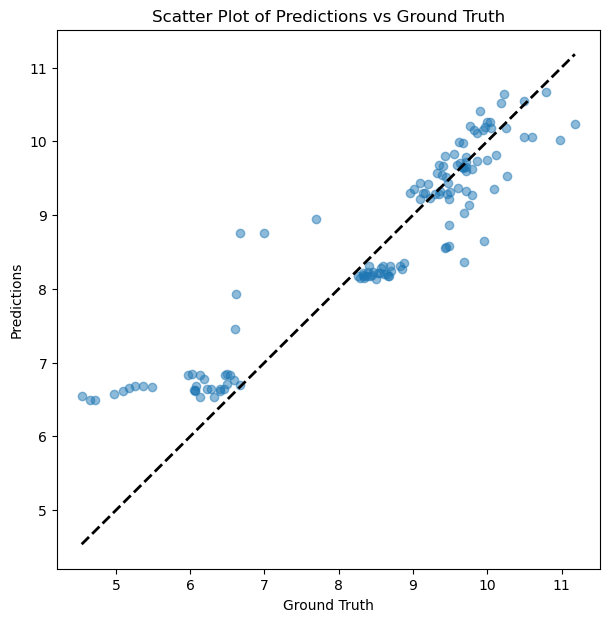

In [23]:
plt.figure(figsize=(14, 7))

plt.plot(y_test.values, label='Ground Truth', color='blue', linewidth=2)
plt.plot(np.concatenate((y_pred, aa)), label='Predictions', color='red', linestyle='dashed', linewidth=2)

plt.title('Comparison of Predictions and Ground Truth')
plt.xlabel('Index')
plt.ylabel('Clot')
plt.legend()
plt.show()

# Scatter Plot to compare predictions with ground truth
plt.figure(figsize=(7, 7))

plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Line of perfect prediction
plt.title('Scatter Plot of Predictions vs Ground Truth')
plt.xlabel('Ground Truth')
plt.ylabel('Predictions')
plt.show()

### Ouverture 
Fine-tuner le XGBoost <br>
Tester de nouveaux modèles pour les indicateurs